Exploration of the data from the [Di-Tech Challenge](http://research.xiaojukeji.com/competition), organized by Didi Chuxing, a ride-hailing company in China. The data is described [here](http://research.xiaojukeji.com/competition/detail.action?competitionId=DiTech2016).

In [1]:
from time import clock
import numpy as np
import pandas as pd

# Warn about chained assignment in pandas?
# pd.options.mode.chained_assignment = None

# import matplotlib
# matplotlib.use('Agg')

from ggplot import *
%matplotlib inline

# Order Info Table

<table>
        <tr>
            <th>Field</th>
            <th>Type</th>
            <th>Meaning</th>
            <th>Example</th>
        </tr>
        <tr>
            <td>order_id</td>
            <td>string</td>
            <td>order ID</td>
            <td>70fc7c2bd2caf386bb50f8fd5dfef0cf</td>
        </tr>
        <tr>
            <td>driver_id</td>
            <td>string</td>
            <td>driver ID</td>
            <td>56018323b921dd2c5444f98fb45509de</td>
        </tr>
        <tr>
            <td>passenger_id</td>
            <td>string</td>
            <td>user ID</td>
            <td>238de35f44bbe8a67bdea86a5b0f4719</td>
        </tr>
        <tr>
            <td>start_district_hash</td>
            <td>string</td>
            <td>departure</td>
            <td>d4ec2125aff74eded207d2d915ef682f</td>
        </tr>
        <tr>
            <td>dest_district_hash</td>
            <td>string</td>
            <td>destination</td>
            <td>929ec6c160e6f52c20a4217c7978f681</td>
        </tr>
        <tr>
            <td>Price</td>
            <td>double</td>
            <td>Price</td>
            <td>37.5</td>
        </tr>
        <tr>
            <td>Time</td>
            <td>string</td>
            <td>Timestamp of the order</td>
            <td>2016-01-15 00:35:11</td>
        </tr>
</table>

The Order Info Table shows the basic information of an order, including the passenger and the driver (if driver_id =NULL, it means the order was not answered by any driver), place of origin, destination, price and time. The fields order_id, driver_id, passenger_id, start_hash, and dest_hash are made not sensitive.

In [2]:
# Columns in order files
columns = ['order_id', 'driver_id', 'passenger_id', 'start_district_hash', 'dest_district_hash', 'price', 'time']

# Open only one file
# order_file_1 = "data/season_1/training_data/order_data/order_data_2016-01-01"
# df = df_1 = pd.read_csv(order_file_1, sep = "\t", names = columns, parse_dates = 'time')

# Files are organized by dates
# n_files = 22
order_files = ["data/season_1/training_data/order_data/order_data_2016-01-{:02d}".format(i) 
#                for i in range(1, n_files)]
               for i in range(10, 16)]


# Open all of them
order_dfs = []
for order_file in order_files:
    order_dfs.append(pd.read_csv(order_file, sep = "\t", names = columns))
df = pd.concat(order_dfs)

# Recognize time column as time
df['time'] = pd.to_datetime(df.time)
# Set the row labels to the time stamp
# df = df.set_index('time')

# Keep first two weeks for training, next one week for validation.
ind = df['time'] < pd.to_datetime('2016-01-15')
df_train = df[ind]
df_valid = df[~ind]

# Keep a random number of the rows
# df_train = df.sample(frac = 0.70, random_state = 111)
# df_valid = df[~df.index.isin(df_train.index)]

# Avoid looking at validation set during the exploration
df = df_train

# Quick look at the data frame
df.head(2)

,order_id,driver_id,passenger_id,start_district_hash,dest_district_hash,price,time
0,8eb94f6832600ee0d342d8a931f64df7,a51979c9a0b257fa81cc401ac8addc97,114cfc989cea164e63d3405fe3055d09,90c5a34f06ac86aee0fd70e2adce7d8a,90c5a34f06ac86aee0fd70e2adce7d8a,7,2016-01-10 19:42:02
1,982ca599b83542f32a62fa63fdc25681,9f5decbb0180ab1979ff293bec7d1f93,d52994586c13b6066fd031ba7f684e24,62afaf3288e236b389af9cfdc5206415,62afaf3288e236b389af9cfdc5206415,8,2016-01-10 14:24:23


In [3]:
df.get_dtype_counts()

datetime64[ns]    1
float64           1
object            5
dtype: int64

In [4]:
# Dates?

print("Dates from {} to {}.".format(df['time'].min(), df['time'].max()))

# How many entries? unique orders/passengers/drivers?

num_entries = df.shape[0]
print("{} entries".format(num_entries))

num_orders = len(df.order_id.unique())
print("{} unique orders ({:.1%})".format(num_orders, num_orders/num_entries))

num_pass = len(df.passenger_id.unique())
print("{} unique passengers ({:.1%})".format(num_pass, num_pass/num_entries))
      
num_drivers = len(df.driver_id.unique())
print("{} unique drivers ({:.1%})".format(num_drivers, num_drivers/num_entries))

num_start_district = len(df.start_district_hash.unique())
print("{} unique starting districts ({:.1%})".format(num_start_district, num_start_district/num_entries))

num_dest_district = len(df.dest_district_hash.unique())
print("{} unique destination districts ({:.1%})".format(num_dest_district, num_dest_district/num_entries))

# Price distribution

print("\n")
print(df.price.describe())

Dates from 2016-01-10 00:00:03 to 2016-01-14 23:59:57.
1979690 entries
1975907 unique orders (99.8%)
654563 unique passengers (33.1%)
66048 unique drivers (3.3%)
66 unique starting districts (0.0%)
538 unique destination districts (0.0%)


count    1979690.000000
mean          16.847202
std           15.982573
min            0.000000
25%            7.900000
50%           12.100000
75%           21.000000
max          512.000000
Name: price, dtype: float64


In [5]:
# Extract the date, and implicitly make the time midnight.
df['date'] = df.time.dt.date
df['timeonly'] = df.time.dt.time

# Compute time slot
df['timeslot_absolute'] = (df['time'] - pd.to_datetime('2016-01-01')).astype('timedelta64[m]')//10 # since begin
df['timeslot'] = df['timeslot_absolute'] % (24*6) + 1 # Timeslot of day, indexed from 1 to 144.
df['time_from_begin'] = df['timeslot_absolute']/6/24

# Drop the time column?
# df = df.drop('time', axis = 1)

# Is it a weekend or weekday?
df['dow'] = df.time.dt.dayofweek
df['weekend'] = df.dow >= 5

df.head(2)

,order_id,driver_id,passenger_id,start_district_hash,dest_district_hash,price,time,date,timeonly,timeslot_absolute,timeslot,time_from_begin,dow,weekend
0,8eb94f6832600ee0d342d8a931f64df7,a51979c9a0b257fa81cc401ac8addc97,114cfc989cea164e63d3405fe3055d09,90c5a34f06ac86aee0fd70e2adce7d8a,90c5a34f06ac86aee0fd70e2adce7d8a,7,2016-01-10 19:42:02,2016-01-10,19:42:02,1414,119,9.819444,6,True
1,982ca599b83542f32a62fa63fdc25681,9f5decbb0180ab1979ff293bec7d1f93,d52994586c13b6066fd031ba7f684e24,62afaf3288e236b389af9cfdc5206415,62afaf3288e236b389af9cfdc5206415,8,2016-01-10 14:24:23,2016-01-10,14:24:23,1382,87,9.597222,6,True


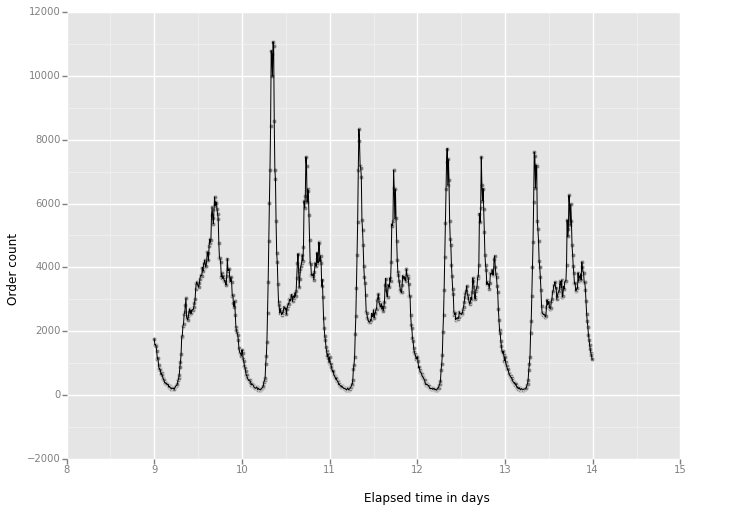

<ggplot: (8770520838464)>

In [6]:
# Plot of gap vs elapsed time in days group by ten minutes interval

# Count how many rows per timeslot
# count = df[['order_id', 'driver_id']].groupby('order_id').count()
count = df.groupby('time_from_begin')['time_from_begin'].count()
count = pd.DataFrame(count)
count.columns = ['count']
count.reset_index(level=0, inplace=True)

ggplot(aes('time_from_begin', 'count'), data = count) + \
    geom_point(color = 'gray') + \
    geom_line() + \
    xlab('Elapsed time in days') + ylab('Order count')

# Gap

In [7]:
# Count how many rows per order_id and driver_id
count = df[['order_id', 'driver_id']].groupby('order_id').count()
count = count.reset_index()
count = count['driver_id']

# Orders picked up by more than one driver?
print("Number of orders taken by more than one driver: {}".format(sum(count > 1)))
# Yes..? Surprising.

# Turns out there are duplicate and almost-duplicate entries. 
# The FAQ recommends just leaving them in.

# Remove the duplicates
# dup = df.duplicated(['order_id', 'driver_id', 'passenger_id', 'time'], keep = 'last')
# df = df[~dup]

# Proportion of orders not picked up by a driver
s = sum(count == 0)
l = len(count)

print("There are {} orders-without-drivers out of {} orders: {:.1%}.".format(s, l, s/l))
# The gap is simply the number of orders not picked up.

# FIXME This might be overcounting gap. Some driver_id still get 1?

Number of orders taken by more than one driver: 2699
There are 316338 orders-without-drivers out of 1975907 orders: 16.0%.


In [8]:
# Was order answered?
df['is_gap'] = df['driver_id'].isnull()

# Proportion of orders not picked up by a driver
s = sum(df['is_gap'])
l = len(df['is_gap'])
print("There are {} orders-without-drivers out of {} orders: {:.1%}.".format(s, l, s/l))

# df.head(2)
# df.describe()

There are 317114 orders-without-drivers out of 1979690 orders: 16.0%.


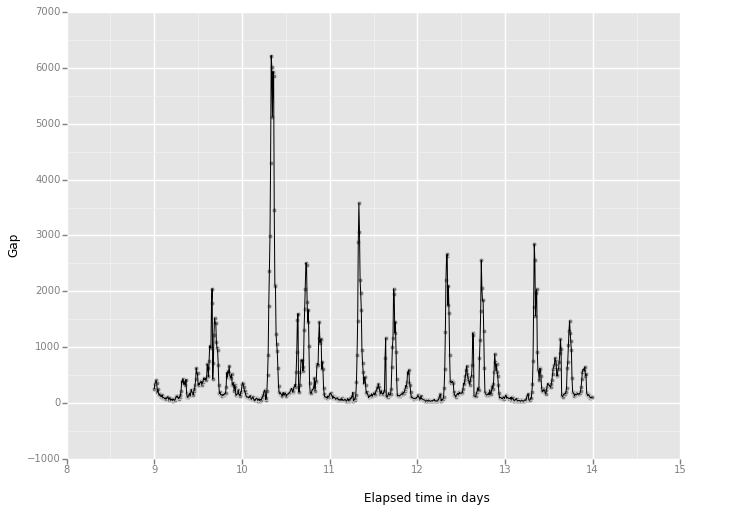

<ggplot: (8770490354759)>

In [9]:
# Plot of gap vs elapsed time in days group by ten minutes interval

cols = ['time_from_begin']
df_select = df[cols + ['is_gap']]
df_gap = df_select.groupby(cols).sum()
df_gap = df_gap.reset_index()

ggplot(aes('time_from_begin', 'is_gap'), data = df_gap) + \
    geom_point(color = 'gray') + \
    geom_line() + \
    xlab('Elapsed time in days') + ylab('Gap')

In [10]:
# Compute gap per timeslot per district
# cols = ['start_district_hash', 'date', 'timeslot']

# Number of missing drivers per group 
# df['gap'] = df.groupby(cols)['is_gap'].transform('sum')

# df.head(2)

# Make new data frame with gap per timeslot per district

def compute_gap(df):
    
    # Gap is when no driver
    df['is_gap'] = df['driver_id'].isnull()
    
    # Aggregate
    cols = ['start_district_hash', 'date', 'timeslot']
    df_select = df[cols + ['is_gap']]
    df_gap = df_select.groupby(cols).sum()

    # Flatten data frame
    df_gap = df_gap.reset_index()
    df_gap = df_gap.rename(columns = {'is_gap': 'gap'})
    
    return df_gap

df_gap = compute_gap(df)

# Sanity check: do the number add up?
print(sum(df_gap.gap))

# Merge back into main data frame
# df = df.merge(df_gap, on = cols, how = 'left')

317114.0


# Weather

<table>
        <tr>
            <th>Field</th>
            <th>Type</th>
            <th>Meaning</th>
            <th>Example</th>
        </tr>
        <tr>
            <td>Time</td>
            <td>string</td>
            <td>Timestamp</td>
            <td>2016-01-15 00:35:11</td>
        </tr>
        <tr>
            <td>Weather</td>
            <td>int</td>
            <td>Weather</td>
            <td>7</td>
        </tr>
        <tr>
            <td>temperature</td>
            <td>double</td>
            <td>Temperature</td>
            <td>-9</td>
        </tr>
        <tr>
            <td>PM2.5</td>
            <td>double</td>
            <td>pm25</td>
            <td>66</td>
        </tr>
</table>

The Weather Info Table shows the weather info every 10 minutes each city. The weather field gives the weather conditions such as sunny, rainy, and snowy etc; all sensitive information has been removed. The unit of temperature is Celsius degree, and PM2.5 is the level of air pollutions.

In [11]:
# Files are organized by dates
n_files = 21
weather_files = ["data/season_1/training_data/weather_data/weather_data_2016-01-{:02d}".format(i)
                 for i in range(1, n_files)]

# Open all of them
columns = ['time', 'weather', 'temperature', 'pm25']
weather_dfs = []
for f in weather_files:
    weather_dfs.append(pd.read_csv(f, sep = "\t", names = columns))
dfw = pd.concat(weather_dfs)

# Extract date and time slot
dfw['time'] = pd.to_datetime(dfw.time)
dfw['date'] = dfw.time.dt.date
dfw['timeslot'] = (dfw['time'] - pd.to_datetime(dfw['date'])).astype('timedelta64[m]')//10 + 1
dfw = dfw.drop('time', axis = 1)

# Merge into main data frame, and fill missing values
# http://pandas.pydata.org/pandas-docs/stable/missing_data.html
df = df.merge(dfw, on = ['date', 'timeslot'], how = 'left')
df.temperature = df.temperature.fillna(method = 'ffill') # forward fill
# df.temperature = df.temperature.interpolate(method = 'time') # time-based interpolation

# Quick peek
dfw.describe()

,weather,temperature,pm25,timeslot
count,4764.000000,4764.000000,4764.000000,4764.000000
mean,3.109152,6.823258,123.513854,67.926113
std,1.647197,3.666475,49.980933,41.519365
min,1.000000,0.000000,26.000000,1.000000
25%,2.000000,4.000000,89.000000,31.000000
50%,3.000000,7.000000,120.000000,66.000000
75%,4.000000,8.000000,160.000000,103.000000
max,9.000000,19.000000,276.000000,144.000000


In [12]:
# Merge into grouped data frame
df_gap = df_gap.merge(dfw, on = ['date', 'timeslot'], how = 'left')
df_gap.temperature = df_gap.temperature.fillna(method = 'ffill')

# Categorical Variables

In [13]:
# Ranking districts
districts_rank = df.start_district_hash.value_counts(sort = True)
districts_rank = districts_rank.rank(ascending = False, method = 'dense')
districts_rank.head(5)

# Create conversion table
districts_convert = pd.DataFrame(data = districts_rank)
districts_convert.reset_index(level=0, inplace=True)
districts_convert.columns = ['start_district_hash', 'start_district_rank']
# districts_convert.head(2)

# Replace hash by rank
df_gap = df_gap.merge(districts_convert, on = 'start_district_hash', how = 'left')
# df_gap = df_gap.drop('start_district_hash', axis = 1)

In [14]:
df_gap.head(2)

,start_district_hash,date,timeslot,gap,weather,temperature,pm25,start_district_rank
0,08232402614a9b48895cc3d0aeb0e9f2,2016-01-10,1,1,3,7,185,60
1,08232402614a9b48895cc3d0aeb0e9f2,2016-01-10,1,1,3,7,185,60


In [15]:
# Rank
df['start_district_count'] = df.groupby('start_district_hash')['start_district_hash'].transform('count')
df['start_district_rank'] = df['start_district_count'].rank(ascending = False, method = 'dense')
df['district_rank'] = df['start_district_rank']

# Number of most popular districts to keep
k = 10

num_entries = df.shape[0]
df_filtered = df[df['start_district_rank'] <= k]
num_top = df_filtered.groupby('start_district_hash')['start_district_count'].mean().sum()

# Look at k top districts
print("The first {} most popular districts account for {} out of {} ({:.1%})".format(
        k, num_top, num_entries, num_top/num_entries))

# Extract most popular districts
districts_top = df_filtered['start_district_hash']

# Look only at most popular districts
# df['district'] = np.nan
# df.loc[df.start_district_hash.isin(districts_top), 'district'] = \
#     df.loc[df.start_district_hash.isin(districts_top), 'start_district_hash']
    
# One-hot encoding
# dummies = pd.get_dummies(df['district'], dummy_na = False)
# df = pd.concat((df.drop('district', axis = 1), dummies.astype(int)), axis = 1)

df.head(2)

The first 10 most popular districts account for 2193290 out of 3282759 (66.8%)


,order_id,driver_id,passenger_id,start_district_hash,dest_district_hash,price,time,date,timeonly,timeslot_absolute,...,time_from_begin,dow,weekend,is_gap,weather,temperature,pm25,start_district_count,start_district_rank,district_rank
0,8eb94f6832600ee0d342d8a931f64df7,a51979c9a0b257fa81cc401ac8addc97,114cfc989cea164e63d3405fe3055d09,90c5a34f06ac86aee0fd70e2adce7d8a,90c5a34f06ac86aee0fd70e2adce7d8a,7,2016-01-10 19:42:02,2016-01-10,19:42:02,1414,...,9.819444,6,True,False,4,7,156,175885,6,6
1,982ca599b83542f32a62fa63fdc25681,9f5decbb0180ab1979ff293bec7d1f93,d52994586c13b6066fd031ba7f684e24,62afaf3288e236b389af9cfdc5206415,62afaf3288e236b389af9cfdc5206415,8,2016-01-10 14:24:23,2016-01-10,14:24:23,1382,...,9.597222,6,True,False,8,7,191,207580,4,4


# Preparation for Validation

In [16]:
# Compute time slot
df_valid['time'] = pd.to_datetime(df_valid.time)
df_valid['date'] = df_valid.time.dt.date
df_valid['timeslot'] = (df_valid['time'] - pd.to_datetime(df_valid['date'])).astype('timedelta64[m]')//10 + 1

# Day of week
df_valid['dow'] = df_valid.time.dt.dayofweek
df_valid['weekend'] = df_valid.dow >= 5

# Compute gap per time slot per district
# df_valid['is_gap'] = df_valid['driver_id'].isnull()
# cols = ['start_district_hash', 'date', 'timeslot']
# df_select = df_valid[cols + ['is_gap']]
# df_gap = df_select.groupby(cols).sum()
# df_gap = df_gap.reset_index().rename(columns = {'is_gap': 'gap'})
# df_valid = df_valid.merge(df_gap, on = cols, how = 'left')

# Compute gap per time slot per district
df_valid_gap = compute_gap(df_valid)

# Merge temperature
df_valid = df_valid.merge(dfw, on = ['date', 'timeslot'], how = 'left')
df_valid.temperature = df_valid.temperature.fillna(method = 'ffill')

# One-hot encoding of districts
# df_valid['district'] = np.nan
# df_valid.loc[df_valid.start_district_hash.isin(districts), 'district'] = \
#     df_valid.loc[df_valid.start_district_hash.isin(districts), 'start_district_hash']
# dummies = pd.get_dummies(df_valid['district'], dummy_na = False)
# df_valid = pd.concat((df_valid.drop('district', axis = 1), dummies.astype(int)), axis = 1)

# Replace district by popularity
df_valid = df_valid.merge(districts_convert, on = 'start_district_hash', how = 'left')

# Time

In [17]:
# Is it a weekend or weekday?
df_gap['dow'] = pd.to_datetime(df_gap.date).dt.dayofweek
df_gap['weekend'] = df_gap.dow >= 5

# Is it a weekend or weekday?
df_valid_gap['dow'] = pd.to_datetime(df_valid_gap.date).dt.dayofweek
df_valid_gap['weekend'] = df_valid_gap.dow >= 5

# Test Data

In [18]:
# Columns in order files
columns = ['datetimeslot']

# Open list of slots
order_file = 'data/season_1/test_set_1/read_me_1.txt'
df_test = pd.read_csv(order_file, sep = "\t", names = columns, skiprows = 1)

# Extract date and timeslot [0,143]
df_test['date'] = pd.to_datetime(df_test.datetimeslot.str[:10])
df_test['timeslot'] = df_test.datetimeslot.str[11:]
df_test['timeslot'] = df_test.timeslot.astype(int)
# df_test.dtypes

# Day of week
df_test['dow'] = df_test.date.dt.dayofweek
df_test['weekend'] = df_test.dow >= 5

# df_test

In [19]:
# Extract timeslots for testing in validation
timeslots = df_test.timeslot.unique()
df_valid_gap_selected = df_valid_gap[df_valid_gap['timeslot'].isin(timeslots)]

df_valid_gap = df_valid_gap_selected

# Predictions by Clusters

In [27]:
# Make first prediction by simply taking the mean per start_district_hash per timeslot per weekend
cols = ['start_district_hash', 'weekend', 'timeslot']
# cols = ['start_district_hash', 'dow', 'timeslot']

df_select = df_gap[cols + ['gap']]
df_grouped = df_select.groupby(cols)
gap_cluster = df_grouped.median() # median, mean, min, max
gap_cluster = gap_cluster.reset_index().rename(columns = {'gap': 'gap_cluster'})

# Work directly on main data frame
# df['gap_cluster'] = df[cols + ['gap']].groupby(cols)['gap'].transform('min')

# Merge back into main data frame
df_cluster = df_gap.merge(gap_cluster, on = cols, how = 'left')

# Quick look
df.head(2)

# Set given outcome and predictions
train_outcome = df_cluster['gap']
train_predict = df_cluster['gap_cluster']

In [28]:
# Validation

df_valid_cluster = df_valid_gap[cols + ['gap']].merge(gap_cluster, on = cols, how = 'left')

# FIXME Some values are missing predictions!
valid_predict = valid_predict.fillna(0)

valid_outcome = df_valid_cluster['gap']
valid_predict = df_valid_cluster['gap_cluster']

In [22]:
# Test

# df_test = df_test.merge(gap_cluster, on = cols, how = 'left')
# test_predict = df_test['gap_cluster']

# Prediction with sklearn

In [23]:
# Select features
cols = ['start_district_rank', 'dow', 'timeslot', 'temperature']
# cols = ['start_district_rank', 'weekend', 'timeslot', 'temperature']
train = df_gap[cols]

# Reference outcome
train_outcome = df_gap['gap']

# Select regressor
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators = 10)
# from sklearn.tree import DecisionTreeRegressor
# reg = DecisionTreeRegressor(max_depth = 3)

# Fit training data
start = clock()
reg.fit(train, train_outcome)
print("Fit in {:.0f} seconds.".format(clock() - start))

# Extrapolate to test data
start = clock()
train_predict = reg.predict(train)
print("Extrapolate in {:.0f} seconds.".format(clock() - start))

Fit in 1 seconds.
Extrapolate in 0 seconds.


In [24]:
# Validation
valid_outcome = df_valid_gap['gap']
valid_predict = reg.predict(df_valid_gap[cols])

# Evaluation
Consider di districts and tj time slots, and the supply-demand gap gapij , and your prediction is sij, we use as the evaluation metrics: 
![MAPE](figures/mape.jpg)
The lowest MAPE will be the best.

In [107]:
def mape(outcome, predict):
    # Compute MAPE score. Lower is better.
    
    # Verify that there are no missing values
    assert not (outcome.isnull().values.any() or predict.isnull().values.any())
    
    # Compute errors summand for summand with nonzero denominator
    diff = (outcome - predict) / outcome.replace({0: np.nan})
    diff = diff.replace({np.nan: 0})
    diff = diff.abs()
    
    # Compute the average over all district and timeslots for which outcome is NONZERO
    nq = len(outcome.nonzero()[0])
    return diff.sum() / nq

# As of June 7th...
# lowest score online is 0.224257,
# 100th is 0.27747,
# 500th is 0.360159.

score = mape(train_outcome, train_predict)
print("Training MAPE: {:.6f}".format(score))

score = mape(valid_outcome, valid_predict)
print("Validation MAPE: {:.6f}".format(score))

# MAPE on training set
# ['start_district_hash', 'weekend', 'timeslot', 'gap_cluster'] -- 0.003352
# ['start_district_hash', 'dow', 'timeslot', 'gap_cluster'] -- 0.011473
# ['start_district_hash', 'dow', 'timeslot', 'ffill-temperature', DTR] -- 0.777944
# ['start_district_hash', 'dow', 'timeslot', 'ffill-temperature', RFR] -- 0.566997

15756.7811282
0.387344357732
40679.0
Training MAPE: 15756.781128
255.858626514
0.766043791958
334.0
Validation MAPE: 255.858627


In [110]:
def mape(outcome, predict):
    
    # Verify that there are no missing values
    assert not (outcome.isnull().values.any() or predict.isnull().values.any())
    
    # Get only the nonzero elements
    idx = outcome != 0
    # idx = np.abs(outcome) < 10^(-5)
    
    return np.mean(np.abs((outcome[idx] - predict[idx]) / outcome[idx]))

score = mape(train_outcome, train_predict)
print("Training MAPE: {:.6f}".format(score))

score = mape(valid_outcome, valid_predict)
print("Validation MAPE: {:.6f}".format(score))

Training MAPE: 0.387344
Validation MAPE: 0.766044


# District Info Table

<table>
        <tr>
            <th>Field</th>
            <th>Type</th>
            <th>Meaning</th>
            <th>Example</th>
        </tr>
        <tr>
            <td>district_hash</td>
            <td>string</td>
            <td>District hash</td>
            <td>90c5a34f06ac86aee0fd70e2adce7d8a</td>
        </tr>
        <tr>
            <td>district_id</td>
            <td>string</td>
            <td>District ID</td>
            <td>1</td>
        </tr>
</table>

The District Info Table shows the information about the districts to be evaluated in the contest. You need to do the prediction given the districts from the District Definition Table. In the submission of the results, you need to map the district hash value to district mapped ID.

In [ ]:
# Use the starting district_hash as the associated disctrict
df['district_hash'] = df['start_district_hash']

# Load district conversion table
district_file = 'data/season_1/training_data/cluster_map/cluster_map'
district = pd.read_csv(district_file, sep = '\t', names = ['district_hash', 'district_id'])

# How many districts?
print("There are {} districts in the district file.".format(district.shape[0]))

# Replace district_hash by district_id in data frame
df = df.merge(district, on = 'district_hash', how = 'left')
# df = df.drop('district_hash', axis = 1)

df.head(2)

# Output
<table class="table table-2">
        <tr>
            <th>Data name</th>
            <th>Data type</th>
            <th>Example</th>
        </tr>
        <tr>
            <td>District ID</td>
            <td>string</td>
            <td>1,2,3,4 (the same as district mapping ID)</td>
        </tr>
        <tr>
            <td>Time slot</td>
            <td>string</td>
            <td>2016-01-23-1 (The first time slot on Jan. 23rd, 2016; one day is uniformly divided into 144 ten minute time slots)</td>
        </tr>
        <tr>
            <td>Prediction value</td>
            <td>double</td>
            <td>6.0</td>
        </tr>
</table>

In [ ]:
# Make the date - timeslot column
df_test['datetimeslot'] = df_test.date.map(str) + '-' + df_test.timeslot.astype(int).map(str)

# Prepare output file
df_test['district_id', 'datetimeslot', 'gap_cluster'].to_csv('predict.csv', index = False, header = False)